For this demonstration we will be simulating a SrTiO3 CeO2 interface downloaded from https://www.materialscloud.org/explore/stoceriaitf/grid/calculations. We first import the multislice library, read in and plot the crystal and set up some basic parameters for our simulation.

(13200, 6)
(13200, 6)


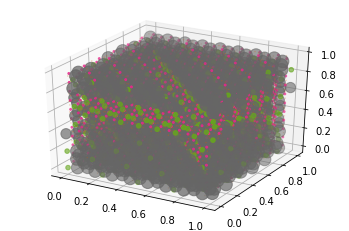

In [2]:
import pyms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Get crystal
# crystal = pyms.crystal('Structures/SrTiO3_CeO2_interface.xyz')
# # A few maniupulations to remove vaccuum at edges and create a psuedo-periodic
# # structure
# crystal = crystal.slice([0.1,0.76],axis=0)
# print(crystal.atoms.shape)
# crystal = crystal.concatenate_crystals(crystal.slice([0.017,0.99],
#                                     axis=0).reflect([0]),axis=0)
# crystal.output_xyz('Interface_prismatic.xyz')

#Output structure for examination in Vesta 

crystal = pyms.crystal('Structures/ESMO_LSMO.p1',temperature_factor_units="B")
crystal.output_vesta_xtl('tiled.xtl')
flipped = crystal.reflect([0,1,2])

# fig,ax=plt.subplots()
# ax.plot(*[flipped.atoms[:,i] for i in [0,2]],'bo')
# ax.set_xlim([0,0.2])
# ax.set_ylim([0,0.2])
flipped = flipped.slice([0.15,0.98],axis=2)
# fig,ax=plt.subplots()
# ax.plot(*[flipped.atoms[:,i] for i in [0,2]],'bo')
# ax.set_ylim([0,0.2])


crystal = crystal.concatenate_crystals(flipped)
crystal.output_vesta_xtl('manipulated.xtl')
crystal.output_xyz('ESMO_LSMO_prismatic.xyz')
#Quick plot of crystal
crystal.quickplot(atomscale=1e-5)

#Subslicing of crystal for multislice
nslices = int(np.ceil(crystal.unitcell[2]/2))
subslices = np.linspace(1.0/nslices,1.0,nslices)
nsubslices = len(subslices)

#Grid size in pixels
# gridshape = [512,512]
gridshape = [1024,1024]
# tiling = [8,8]
tiling = [1,1]

#Size of real space grid
rsize = np.zeros((3,))
rsize[:3]  = crystal.unitcell[:3]
rsize[:2] *= np.asarray(tiling)

#Number of transmission functions
nT = 4

#Probe accelerating voltage in eV
eV = 3e5

#Objective aperture in mrad
app = 15

#Number of frozen phonon passes
nfph = 5

Set up and look at transmission functions

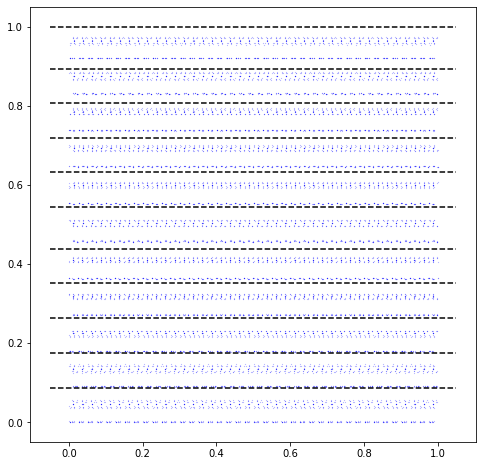

In [25]:
#Subslice every 2 Angstrom

step=0.087
subslices = np.concatenate([np.arange(step,0.5,step=0.088),np.arange(0.545,1.0,step)])
subslices[-1] = 1.0
nsubslices = subslices.shape[0]
# print(nsubsubslices)
fig,ax =plt.subplots(figsize=(8,8))
ax.plot(crystal.atoms[:,0],crystal.atoms[:,2],'bo',markersize=0.1)
x0,x1 = ax.get_xlim()
for slce in subslices:
    ax.plot([x0,x1],[slce,slce],'k--')

[0.087 0.175 0.263 0.351 0.439 0.545 0.632 0.719 0.806 0.893 1.   ]
Max resolution of grid is 97.1 mrad, 


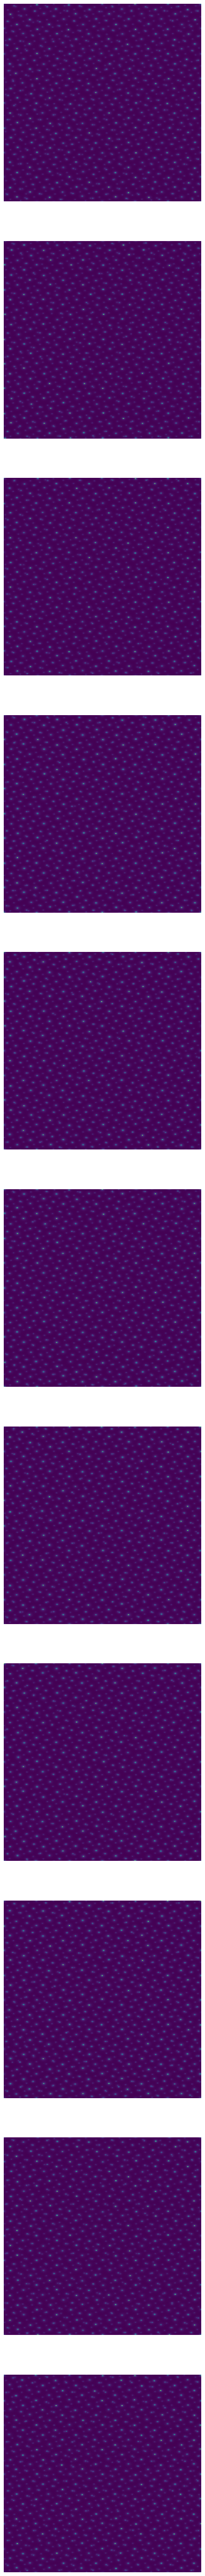

In [29]:
import torch
from pyms.utils import cx_to_numpy

#Choose GPU if available and CPU if not
# if torch.cuda.is_available():
#     device = torch.device("cuda:0")
#     torch.cuda.empty_cache()
# else:
device = torch.device("cpu")




#Initialize array to store transmission functions in
T = torch.zeros(nT,nsubslices,*gridshape,2,device=device)
print(subslices)
#Make transmission functions
for i in range(nT):
    T[i,:,:,:] = crystal.make_transmission_functions(gridshape,eV,subslices,tiling,fftout=True,device=device)


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

# from PIL import Image
# Image.fromarray(np.angle(cx_to_numpy(T[0,0,...]))).save('Potential.tif')

#Now plot transmission function with slider widget to inspect individual slices

# fig,ax = plt.subplots(figsize=(4,4))
# img = np.angle(cx_to_numpy(T[0,0,...]))
# p = ax.imshow(img,vmax=0.6*np.amax(img),vmin=np.amin(img))
# ax.set_axis_off()

# def plot_img(i,img,p):
#     p.set_data(np.angle(cx_to_numpy(img[0,i,...])))
#     fig.canvas.draw_idle()
#     ax.set_title('slice {0}'.format(i))

# widg = widgets.IntSlider(
#     value=0,
#     min=0,
#     max=T.shape[1]-1,
#     step=1,
#     description='Slice:',
#     disabled=False,
#     continuous_update=True,
#     orientation='horizontal',
#     readout=True,
#     readout_format='d'
# )
# interact(plot_img,i=widg,img=fixed(T), p=fixed(p))

# Check that the grid is of sufficient resolution for our planned 150 mrad
# outer angle HAADF detector
print('Max resolution of grid is {0:.1f} mrad, '.format(pyms.max_grid_resolution(gridshape,rsize,eV=eV)))
#Plot the different slices of the unit cell
from PIL import Image
nrows = nsubslices
figsize = 8
fig,ax = plt.subplots(nrows=nrows,figsize=(figsize,figsize*nrows))
import os,glob
for f in glob.glob('Potentials/*'): os.remove(f)
for i in range(nrows):
    ax[i].imshow(np.angle(cx_to_numpy(T[0,i,:gridshape[0]//tiling[0]*4,:gridshape[1]//tiling[1]*4])))
    ax[i].set_axis_off()
    Image.fromarray(np.angle(cx_to_numpy(T[0,i,...]))).save('Potentials/Potential_{0}.tiff'.format(i))

Make some detectors

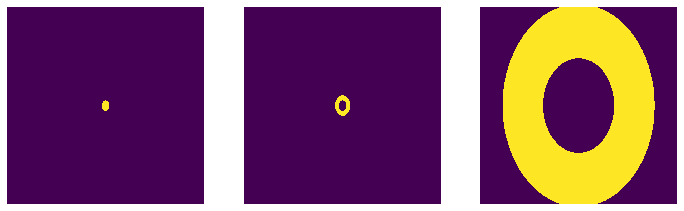

In [30]:
#Define detector inner...
betamin = [0  ,7.5,70]
#... and outer angles
betamax = [7.5,15 ,150]

ndet = len(betamax)

detectors = np.zeros((ndet,*gridshape),dtype = np.float)

fig,ax = plt.subplots(ncols=3,figsize=(12,4))

for i in range(ndet):
    detectors[i,...] = pyms.make_detector(gridshape,rsize,eV,betamax[i],betamin[i])
    
    ax[i].imshow(np.fft.fftshift(detectors[i,...]))
    ax[i].set_axis_off()

plt.show()

Now calculate TEM images for a range of defocii

In [31]:
# Make Fresnel free-space propagators for multislice algorithm
propagators = pyms.make_propagators(gridshape, rsize, eV, subslices)

# Set up thickness series
tstep = 100
thicknesses = np.asarray([200])
nt = thicknesses.shape[0]

# alpha = 1.1*app
# PRISM_factor=[16,16]
# S = pyms.scattering_matrix(
#     rsize,
#     propagators,
#     T,
#     nslices,
#     eV,
#     alpha,
#     batch_size=1,
#     device=None,
#     PRISM_factor=PRISM_factor,
#     showProgress=True
#     )



In [ ]:

nfph = 2
print(np.ceil(thicknesses / crystal.unitcell[2]).astype(np.int))
images = []
# Iteration over frozen phonon configurations
for ifph in range(nfph):
    # Make probe
    probe = pyms.focused_probe(gridshape, rsize, eV, app)
    # Run multislice
    print("Frozen phonon iteration: {0:2d}/{1:2d}".format(ifph+1, nfph))
    images.append(
        pyms.STEM(
            rsize[:2],
            probe,
            propagators,
            T,
            np.ceil(thicknesses / crystal.unitcell[2]).astype(np.int),
            eV,
            app,
            batch_size=1,
            detectors=detectors,
            tiling=tiling
        )
    )
images = np.average(images, axis=0)
    

Plot resulting images

In [ ]:
nrows, ncols = [ndet, nt]
fig, ax = plt.subplots(nrows=ndet, ncols=nt, figsize=(2 * ncols, 2 * nrows))

for col in range(ncols):
    ax[0,col].set_title('t = {0} '.format(thicknesses[col]))
    for row in range(nrows):
        ax[row, col].imshow(np.tile(images[row, col, ...],(2,2)))
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        if(col==0): ax[row,0].set_ylabel('Detector {0}'.format(row+1))